In [ ]:
"""
This file analyzes how the evolution of the feed position from a rather large 
value to a very small value influences the resonance frequency.

In this code, we do not modify either the meander distance or the width of the meandered track.
"""

"\nCe fichier analyse comment l'evolutin de la position feed d'une valeur assez \ngrandre a une valuer tres petite influence la frequence de raisonnance\n\nDans ce code, On ne touche Ni a la distance meandre ni a la largeur de la piste meandree\n"

In [ ]:
from backend.utils.ifa_meander_project_v2.geometry import *
from backend.utils.ifa_meander_project_v2.meshing import *
from backend.utils.ifa_meander_project_v2.frequency import *
from backend.utils.ifa_meander_project_v2.simulation import *

In [ ]:
fLow = 700e6
fHigh = 1000e6
fC = 868e6
step = 4e6

frequencies, fc_index, nPoints = generate_frequencies(fLow, fHigh, fC, step)

print(f"Number of frequencies (nPoints): {nPoints}")
print(f"Index of fC: {fc_index}")


Nombre de fréquences (nPoints) : 76
Index de fC : 42


In [4]:
mesh_name = "ifa_meander_anlyse_3.msh"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/ifa_meander_anlyse_3.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [ ]:
a = 15 / 1000  # Width
b = 30 / 1000  # Height

terminal_a = 50 / 1000
terminal_b = b
x_t = np.array([-terminal_a, 0, 0, -terminal_a])
y_t = np.array([terminal_b, terminal_b, 0, 0])

# Fix the short feed and the track width
largeur_piste    = 0.813 / 1000
distance_meandre = 0.813 / 1000

mesh_size = 6 / 1000

In [6]:
feed_list = np.linspace(b - 3 * largeur_piste / 2 - 0.5 / 1000, largeur_piste / 2, 50)
print(f"Feed min: {feed_list[-1] * 1000:.2f} mm")
print(f"Feed max: {feed_list[0] * 1000:.2f} mm")

np.save('data/analyse_feed_position/feed_list.npy', feed_list)

Feed min: 0.41 mm
Feed max: 28.28 mm


In [ ]:
def creation_ifa(largeur, hauteur, width, dist_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size):
    x, y, N, distance_meandre = ifa_creation(largeur, hauteur, width, dist_meandre)
    x_m, y_m = trace_meander(x, y, width)
    feed_wid = width # The track width is the same everywhere
    feed_x = np.array([0, distance_meandre, distance_meandre, 0])
    feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed - feed_wid/2, feed - feed_wid/2])
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, mesh_size)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)
    return N, distance_meandre

def plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC=None):
    from matplotlib import pyplot as plt
    frequencies = np.linspace(fLow, fHigh, nPoints)
    frequencies_mhz = np.array(frequencies) / 1e6
    s11_db = np.array(s11_db)

    # Find the minimum of S11
    min_index = np.argmin(s11_db)
    f_resonance = frequencies[min_index] / 1e6
    s11_min = s11_db[min_index]

    # Plot
    fig_size = 7
    Fibonacci = (1 + np.sqrt(5)) / 2
    plt.figure(figsize=(fig_size, fig_size / Fibonacci))
    plt.plot(frequencies_mhz, s11_db, label="S11 (dB)", color='blue')
    plt.plot(f_resonance, s11_min, 'ro', 
            label=f"Resonance: {f_resonance:.2f} MHz (S11={s11_min:.2f} dB)")
    
    if fC:
        fC_mhz = fC / 1e6
        idx_fc = np.argmin(np.abs(frequencies - fC))
        s11_fc = s11_db[idx_fc]
        plt.axvline(fC_mhz, color='green', linestyle='--', 
                   label=f"fC = {fC_mhz:.2f} MHz (S11={s11_fc:.2f} dB)")

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("S11 (dB)")
    plt.title("S11 vs Frequency curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
iteration = 1
frequences_resonance = []
Resistance_R = []
for feed in feed_list:
    try:
        print(f"\n------------------------------------------------------Iteration N°{iteration}------------------------------------------------------")
        print(f"Meander distance {distance_meandre * 1000} mm")
        print(f"IFA track width {largeur_piste * 1000} mm")
        print(f"Feed position = {feed * 1000} mm\n")
        N_list_elem, new_distance_meandre_elem = creation_ifa(a, b, largeur_piste, distance_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size)
        print(f"Number of meanders {N_list_elem}")
        print(f"New meander distance {new_distance_meandre_elem * 1000} mm")
        feed_point = [0, feed, 0]
        frequence_resonance, s11_db, R_res = analysis(frequencies, ifa_meander_mat, feed_point)
        frequences_resonance.append(frequence_resonance)
        Resistance_R.append(R_res)
        if frequence_resonance == fC:
            plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)

        iteration += 1
    except ValueError as e:
        print(f"Error: {e}")

np.save(f'data/analyse_feed_position/frequences_resonance.npy', frequences_resonance)
np.save(f'data/analyse_feed_position/Resistance_R.npy', Resistance_R)


Iteration N°1
distance meandres 0.813 mm
Largeur de piste ifa 0.813 mm
position feed = 28.2805 mm

Number of meanders 9
New distance meandres 0.8536666666666667 mm
Simulation 1/76 | f = 700.00 MHz | S11 = -0.00 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.00 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.01 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.01 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.01 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.01 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.01 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.01 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -0.01 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -0.01 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -0.01 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -0.01 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -0.01 dB
Simulation 14/76 | f = 752.00 MHz | S11 = -0.01 dB
Simulation 15/76 | f = 756.00 MHz | S11 = -0.02 dB
Simulation 16/76 | f = 760.00 MHz | S11 = -0.02 dB
Simulation 17/76 | f = 764.0

In [ ]:
# Load and display feed_list.npy
loaded_feed_list = np.load('data/analyse_feed_position/feed_list.npy')
print("\nContents of loaded_feed_list.npy:", loaded_feed_list / b * 100)

# Load and display frequences_resonance.npy
loaded_frequences_resonance = np.load('data/analyse_feed_position/frequences_resonance.npy')
print("\nContents of frequences_resonance.npy:", loaded_frequences_resonance * 1e-6)

# Load and display Resistance_R.npy
loaded_Resistance_res = np.load('data/analyse_feed_position/Resistance_R.npy')
print("\nContents of Resistance_R.npy:", loaded_Resistance_res)


Contenu de loaded_largeur_piste_list.npy : [94.26833333 92.37214286 90.47595238 88.5797619  86.68357143 84.78738095
 82.89119048 80.995      79.09880952 77.20261905 75.30642857 73.4102381
 71.51404762 69.61785714 67.72166667 65.82547619 63.92928571 62.03309524
 60.13690476 58.24071429 56.34452381 54.44833333 52.55214286 50.65595238
 48.7597619  46.86357143 44.96738095 43.07119048 41.175      39.27880952
 37.38261905 35.48642857 33.5902381  31.69404762 29.79785714 27.90166667
 26.00547619 24.10928571 22.21309524 20.31690476 18.42071429 16.52452381
 14.62833333 12.73214286 10.83595238  8.9397619   7.04357143  5.14738095
  3.25119048  1.355     ]

Contenu de frequences_resonance.npy : [848. 840. 832. 832. 836. 844. 848. 872. 868. 864. 860. 856. 848. 852.
 852. 856. 860. 864. 880. 880. 876. 872. 868. 872. 872. 876. 880. 884.
 896. 896. 892. 888. 888. 888. 892. 892. 896. 896. 900. 908. 908. 904.
 900. 904. 908. 908. 912. 912. 916. 916.]


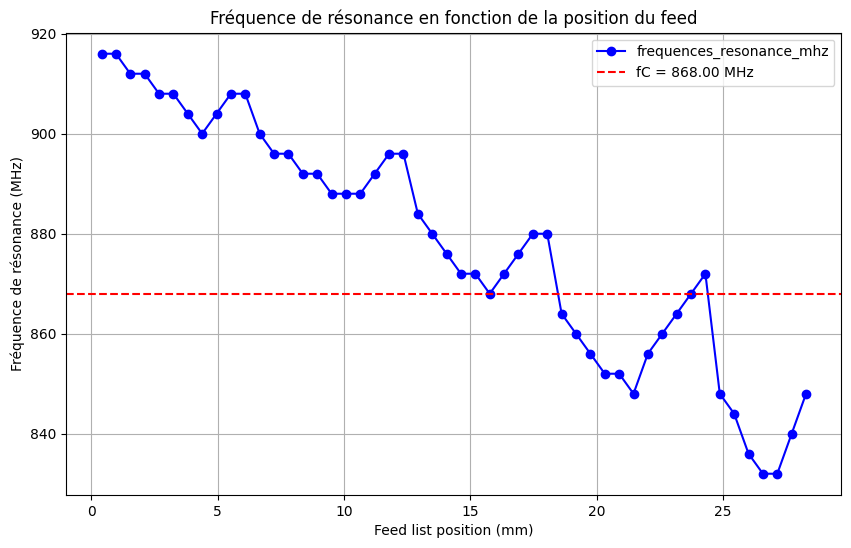

In [ ]:
from matplotlib import pyplot as plt

# Convert data
frequences_resonance_mhz = np.array(loaded_frequences_resonance) * 1e-6
loaded_feed_list_mm = np.array(loaded_feed_list) * 1000  # Convert to mm

plt.figure(figsize=(10, 6))
plt.plot(loaded_feed_list_mm, frequences_resonance_mhz, marker='o', linestyle='-', color='b', label='Resonance frequencies')

# Add a horizontal line for fC
plt.axhline(y=fC * 1e-6, color='r', linestyle='--', label=f'fC = {fC * 1e-6:.2f} MHz')

plt.xlabel('Feed position (mm)')
plt.ylabel('Resonance frequency (MHz)')
plt.title('Resonance frequency as a function of feed position')
plt.legend()
plt.grid(True)
plt.show()